### Cab-Driver Agent

In [1]:
# Importing libraries
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam
import time
# for plotting graphs
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [2]:
from Env import CabDriver
env=CabDriver()
action_space, state_space, state = env.reset()

#### Defining Time Matrix

In [3]:
# Already imported time_matrix in enviroment so no need to pass via arguements
Time_matrix = np.load("TM.npy")

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [5]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor =0.95
        self.learning_rate = 0.01  
        self.epsilon_max = 1
        self.epsilon=1
        self.epsilon_decay = -0.0005
        self.epsilon_min = 0.00001
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)
        # for tracking states which is (0,0,0) and action as (0,4)
        self.states_tracked=[]
        self.track_state=env.state_encod_arch1((0,0,0)).reshape(1,36)
        
        # create main model and target model
        self.model = self.build_model()
        #self.model.load_weights("model_weights.h5")       

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        # hidden layers
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.summary()
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
       
        return model



    def get_action(self, state, actions_idx):
        
        if np.random.rand() <= self.epsilon:
            return random.choice(actions_idx)
        else:
            #return random.choice(actions)
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = env.state_encod_arch1(state).reshape(1,36)
            q_value = self.model.predict(state)
            # check for q values whose requests are possible on given day and time
            possible_q=[q_value[0][k] for k in actions_idx]
            return actions_idx[np.argmax(possible_q)]
             


    def append_sample(self, state, action_idx, reward, next_state,done):
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action_idx, reward, next_state,done))
    
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            
            # sample minibatch from memory
            minibatch = random.sample(self.memory, self.batch_size)

            # initialise two matrices - update_input and update_output
            update_input = np.zeros((self.batch_size, self.state_size))
            update_output = np.zeros((self.batch_size, self.state_size))
            actions, rewards,done = [], [],[]

            # populate update_input and update_output and the lists rewards, actions, done
            for i in range(self.batch_size):
                state, action, reward, next_state,don = minibatch[i]
                update_input[i] = env.state_encod_arch1(state)
                actions.append(action)
                rewards.append(reward)
                done.append(don)
                update_output[i] = env.state_encod_arch1(next_state)


            # predict the target q-values from states s
            target = self.model.predict(update_input)

            # target for q-network
            target_qval = self.model.predict(update_output)

            # update the target values
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
            # model fit
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            

    def save_tracking_states(self):
        # Using the model to predict q_value of state(0,0,0) of action of index-4 (0,4)
        q_value = self.model.predict(self.track_state)
        self.states_tracked.append(q_value[0][4])
        
    def save(self, name):
        with open(name, 'wb') as file:  
            pickle.dump(self.model, file,pickle.HIGHEST_PROTOCOL)
            

In [7]:
Episodes = 20000

### DQN block

In [8]:
start_time = time.time()
state_size = 36 # m + t + d value
action_size = len(env.action_space)

agent = DQNAgent(state_size, action_size)

rewards_per_episode, episodes = [], []
reward_initial_stat=[]
score_track=[]

for episode in range(Episodes):
        done = False
        score = 0
        # total_time is variable to track total number of hours cab is running for defining terminal state
        total_time=0
        env = CabDriver()
        action_space, state_space, state = env.reset()
        
        # Saving the initial state such that Reward can be tracked if initial state is [0,0,0]
        initial_state = env.state_init
        
        while not done:
            possible_act_idx,actions=env.requests(state)
            #getting action via epsilon-greedy policy
            action = agent.get_action(state,possible_act_idx)
            #finding the next state,reward,time taken for current action from enviroment using step function
            next_state,reward,curr_time_taken=env.step(state, env.action_space[action])

            total_time+=curr_time_taken

            if total_time>720:
                #terminal state so turning done to true
                done=True
                #reward=0  #Terminal state
            else:
                pass
            
            #here we are tracking and appending terminal state to the memory buffer
            agent.append_sample(state, action, reward, next_state,done)
            agent.train_model()

            score += reward
            state = next_state
            
        rewards_per_episode.append(score)
        episodes.append(episode)
        #Epsilon value based on epsilon decay rate , new epsilon value is getting assigned to Agent object of DQNAgent class
        agent.epsilon = (1 - 0.00001) * np.exp(agent.epsilon_decay * episode)
        
        if ((episode + 1) % 10 == 0):
            print("episode {0}, reward {1}, memory_length {2}, epsilon {3} total_time {4}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon, total_time)) 
        
        
        if ((episode + 1) % 5 == 0):            
            agent.save_tracking_states()
            #Tracking and saving state of (0,0,0) and action (0,4)

    # Total rewards per episode
        score_track.append(score)

        if(episode % 100 == 0):
            #saving model and weights every 100th episode
            print("Saving Model {}".format(episode))
            agent.model.save_weights("model_weights.h5")
            agent.save(name="model_weights.pkl")


elapsed_time = time.time() - start_time
print(elapsed_time)        

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                1184      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 21)                693       
Total params: 2,933
Trainable params: 2,933
Non-trainable params: 0
_________________________________________________________________

Saving Model 0
episode 9, reward -186.0, memory_length 1443, epsilon 0.9955001547284723 total_time 723
episode 19, reward 88.0, memory_length 2000, epsilon 0.9905350769930761 total_time 724
episode 29, reward -189.0, memory_length 2000, epsilon 0.9855947626861951 total_time 729
episode 39, reward -83.0, memory_length 2000, epsilon 0.9806790882997144 total_time 724
episode 49, re

Saving Model 800
episode 809, reward 252.0, memory_length 2000, epsilon 0.6673037095460755 total_time 729
episode 819, reward 542.0, memory_length 2000, epsilon 0.6639755184099142 total_time 725
episode 829, reward 166.0, memory_length 2000, epsilon 0.6606639266962953 total_time 721
episode 839, reward -50.0, memory_length 2000, epsilon 0.6573688516152534 total_time 721
episode 849, reward 299.0, memory_length 2000, epsilon 0.6540902107897397 total_time 725
episode 859, reward 381.0, memory_length 2000, epsilon 0.6508279222535631 total_time 732
episode 869, reward 161.0, memory_length 2000, epsilon 0.64758190444934 total_time 722
episode 879, reward 116.0, memory_length 2000, epsilon 0.6443520762264566 total_time 722
episode 889, reward -23.0, memory_length 2000, epsilon 0.6411383568390387 total_time 721
episode 899, reward -15.0, memory_length 2000, epsilon 0.6379406659439346 total_time 723
Saving Model 900
episode 909, reward 463.0, memory_length 2000, epsilon 0.6347589235987051 tota

Saving Model 1700
episode 1709, reward 492.0, memory_length 2000, epsilon 0.42549163088821684 total_time 726
episode 1719, reward 728.0, memory_length 2000, epsilon 0.4233694825258223 total_time 731
episode 1729, reward 294.0, memory_length 2000, epsilon 0.4212579184225415 total_time 726
episode 1739, reward 411.0, memory_length 2000, epsilon 0.4191568857891617 total_time 726
episode 1749, reward 855.0, memory_length 2000, epsilon 0.4170663320997578 total_time 729
episode 1759, reward 733.0, memory_length 2000, epsilon 0.4149862050903786 total_time 721
episode 1769, reward 638.0, memory_length 2000, epsilon 0.4129164527577405 total_time 731
episode 1779, reward 740.0, memory_length 2000, epsilon 0.41085702335792745 total_time 725
episode 1789, reward 731.0, memory_length 2000, epsilon 0.40880786540509717 total_time 725
episode 1799, reward 382.0, memory_length 2000, epsilon 0.4067689276701942 total_time 721
Saving Model 1800
episode 1809, reward 535.0, memory_length 2000, epsilon 0.404

episode 2599, reward 1156.0, memory_length 2000, epsilon 0.2726653663217522 total_time 721
Saving Model 2600
episode 2609, reward 1000.0, memory_length 2000, epsilon 0.27130544213378754 total_time 727
episode 2619, reward 820.0, memory_length 2000, epsilon 0.2699523005960067 total_time 727
episode 2629, reward 759.0, memory_length 2000, epsilon 0.26860590787980093 total_time 723
episode 2639, reward 853.0, memory_length 2000, epsilon 0.26726623032528185 total_time 724
episode 2649, reward 702.0, memory_length 2000, epsilon 0.2659332344404412 total_time 729
episode 2659, reward 1110.0, memory_length 2000, epsilon 0.2646068869003122 total_time 723
episode 2669, reward 668.0, memory_length 2000, epsilon 0.2632871545461373 total_time 725
episode 2679, reward 931.0, memory_length 2000, epsilon 0.261974004384539 total_time 721
episode 2689, reward 977.0, memory_length 2000, epsilon 0.26066740358669477 total_time 728
episode 2699, reward 1046.0, memory_length 2000, epsilon 0.25936731948751673

episode 3489, reward 700.0, memory_length 2000, epsilon 0.17473058597222385 total_time 724
episode 3499, reward 1214.0, memory_length 2000, epsilon 0.17385911353901257 total_time 722
Saving Model 3500
episode 3509, reward 844.0, memory_length 2000, epsilon 0.17299198759269493 total_time 724
episode 3519, reward 865.0, memory_length 2000, epsilon 0.1721291864550771 total_time 727
episode 3529, reward 881.0, memory_length 2000, epsilon 0.17127068855608577 total_time 722
episode 3539, reward 798.0, memory_length 2000, epsilon 0.17041647243322863 total_time 726
episode 3549, reward 858.0, memory_length 2000, epsilon 0.16956651673105824 total_time 723
episode 3559, reward 799.0, memory_length 2000, epsilon 0.16872080020063768 total_time 724
episode 3569, reward 637.0, memory_length 2000, epsilon 0.16787930169900972 total_time 724
episode 3579, reward 790.0, memory_length 2000, epsilon 0.16704200018866794 total_time 724
episode 3589, reward 814.0, memory_length 2000, epsilon 0.16620887473703

episode 4379, reward 1028.0, memory_length 2000, epsilon 0.11197160125635315 total_time 725
episode 4389, reward 1043.0, memory_length 2000, epsilon 0.11141314056525843 total_time 722
episode 4399, reward 1250.0, memory_length 2000, epsilon 0.11085746520848058 total_time 722
Saving Model 4400
episode 4409, reward 1057.0, memory_length 2000, epsilon 0.11030456129410682 total_time 721
episode 4419, reward 1432.0, memory_length 2000, epsilon 0.10975441499951036 total_time 727
episode 4429, reward 1263.0, memory_length 2000, epsilon 0.10920701257100535 total_time 723
episode 4439, reward 1214.0, memory_length 2000, epsilon 0.10866234032350246 total_time 722
episode 4449, reward 1074.0, memory_length 2000, epsilon 0.10812038464016717 total_time 723
episode 4459, reward 962.0, memory_length 2000, epsilon 0.10758113197207911 total_time 722
episode 4469, reward 1203.0, memory_length 2000, epsilon 0.10704456883789358 total_time 726
episode 4479, reward 1356.0, memory_length 2000, epsilon 0.1065

episode 5259, reward 1252.0, memory_length 2000, epsilon 0.07211378933609025 total_time 727
episode 5269, reward 812.0, memory_length 2000, epsilon 0.07175412031128199 total_time 725
episode 5279, reward 922.0, memory_length 2000, epsilon 0.0713962451432187 total_time 721
episode 5289, reward -332.0, memory_length 2000, epsilon 0.07104015488500255 total_time 727
episode 5299, reward 490.0, memory_length 2000, epsilon 0.07068584063435851 total_time 721
Saving Model 5300
episode 5309, reward 674.0, memory_length 2000, epsilon 0.07033329353341192 total_time 722
episode 5319, reward 519.0, memory_length 2000, epsilon 0.06998250476846683 total_time 726
episode 5329, reward 953.0, memory_length 2000, epsilon 0.0696334655697859 total_time 722
episode 5339, reward 822.0, memory_length 2000, epsilon 0.06928616721137094 total_time 723
episode 5349, reward 1158.0, memory_length 2000, epsilon 0.06894060101074495 total_time 726
episode 5359, reward 1441.0, memory_length 2000, epsilon 0.068596758328

episode 6139, reward 1295.0, memory_length 2000, epsilon 0.046443906794759175 total_time 731
episode 6149, reward 1632.0, memory_length 2000, epsilon 0.046212266843247196 total_time 723
episode 6159, reward 1201.0, memory_length 2000, epsilon 0.04598178220081319 total_time 730
episode 6169, reward 731.0, memory_length 2000, epsilon 0.04575244710532907 total_time 725
episode 6179, reward 1161.0, memory_length 2000, epsilon 0.045524255823405545 total_time 729
episode 6189, reward 903.0, memory_length 2000, epsilon 0.04529720265024866 total_time 723
episode 6199, reward 1258.0, memory_length 2000, epsilon 0.045071281909517265 total_time 724
Saving Model 6200
episode 6209, reward 1276.0, memory_length 2000, epsilon 0.04484648795318105 total_time 733
episode 6219, reward 1246.0, memory_length 2000, epsilon 0.04462281516137944 total_time 721
episode 6229, reward 922.0, memory_length 2000, epsilon 0.044400257942280974 total_time 721
episode 6239, reward 958.0, memory_length 2000, epsilon 0.04

episode 7019, reward 1237.0, memory_length 2000, epsilon 0.029911567513215692 total_time 721
episode 7029, reward 1530.0, memory_length 2000, epsilon 0.029762382947864045 total_time 729
episode 7039, reward 1312.0, memory_length 2000, epsilon 0.029613942443636205 total_time 724
episode 7049, reward 1326.0, memory_length 2000, epsilon 0.029466242289511866 total_time 723
episode 7059, reward 1038.0, memory_length 2000, epsilon 0.029319278792979464 total_time 723
episode 7069, reward 958.0, memory_length 2000, epsilon 0.029173048279943936 total_time 721
episode 7079, reward 1389.0, memory_length 2000, epsilon 0.029027547094634832 total_time 723
episode 7089, reward 1487.0, memory_length 2000, epsilon 0.02888277159951494 total_time 725
episode 7099, reward 1102.0, memory_length 2000, epsilon 0.028738718175189356 total_time 730
Saving Model 7100
episode 7109, reward 895.0, memory_length 2000, epsilon 0.028595383220314963 total_time 721
episode 7119, reward 790.0, memory_length 2000, epsilon

episode 7889, reward 1186.0, memory_length 2000, epsilon 0.01936070078822371 total_time 724
episode 7899, reward 1354.0, memory_length 2000, epsilon 0.019264138890198193 total_time 730
Saving Model 7900
episode 7909, reward 1272.0, memory_length 2000, epsilon 0.019168058596648274 total_time 723
episode 7919, reward 1798.0, memory_length 2000, epsilon 0.0190724575055616 total_time 724
episode 7929, reward 1173.0, memory_length 2000, epsilon 0.018977333226905934 total_time 723
episode 7939, reward 1555.0, memory_length 2000, epsilon 0.018882683382569338 total_time 724
episode 7949, reward 1439.0, memory_length 2000, epsilon 0.018788505606300788 total_time 722
episode 7959, reward 1381.0, memory_length 2000, epsilon 0.01869479754365095 total_time 730
episode 7969, reward 1608.0, memory_length 2000, epsilon 0.0186015568519134 total_time 726
episode 7979, reward 1230.0, memory_length 2000, epsilon 0.018508781200065983 total_time 726
episode 7989, reward 1340.0, memory_length 2000, epsilon 0

episode 8759, reward 1610.0, memory_length 2000, epsilon 0.012531497550087062 total_time 722
episode 8769, reward 1247.0, memory_length 2000, epsilon 0.012468996445309154 total_time 728
episode 8779, reward 1606.0, memory_length 2000, epsilon 0.012406807066091805 total_time 721
episode 8789, reward 1232.0, memory_length 2000, epsilon 0.012344927857697297 total_time 722
episode 8799, reward 1045.0, memory_length 2000, epsilon 0.012283357273142198 total_time 727
Saving Model 8800
episode 8809, reward 1127.0, memory_length 2000, epsilon 0.012222093773158674 total_time 725
episode 8819, reward 895.0, memory_length 2000, epsilon 0.012161135826156058 total_time 721
episode 8829, reward 1070.0, memory_length 2000, epsilon 0.01210048190818249 total_time 722
episode 8839, reward 929.0, memory_length 2000, epsilon 0.01204013050288686 total_time 725
episode 8849, reward 1048.0, memory_length 2000, epsilon 0.011980080101480892 total_time 721
episode 8859, reward 968.0, memory_length 2000, epsilon 

episode 9629, reward 1266.0, memory_length 2000, epsilon 0.00811119558974631 total_time 726
episode 9639, reward 1847.0, memory_length 2000, epsilon 0.008070740832970229 total_time 725
episode 9649, reward 1313.0, memory_length 2000, epsilon 0.008030487845135315 total_time 722
episode 9659, reward 1378.0, memory_length 2000, epsilon 0.007990435619914792 total_time 727
episode 9669, reward 1824.0, memory_length 2000, epsilon 0.007950583156000935 total_time 726
episode 9679, reward 1255.0, memory_length 2000, epsilon 0.007910929457080072 total_time 721
episode 9689, reward 1385.0, memory_length 2000, epsilon 0.007871473531807663 total_time 722
episode 9699, reward 1462.0, memory_length 2000, epsilon 0.007832214393783524 total_time 721
Saving Model 9700
episode 9709, reward 1780.0, memory_length 2000, epsilon 0.007793151061527156 total_time 724
episode 9719, reward 1204.0, memory_length 2000, epsilon 0.00775428255845322 total_time 724
episode 9729, reward 1230.0, memory_length 2000, epsil

episode 10499, reward 1426.0, memory_length 2000, epsilon 0.005250090313001966 total_time 721
Saving Model 10500
episode 10509, reward 867.0, memory_length 2000, epsilon 0.005223905378325572 total_time 723
episode 10519, reward 1372.0, memory_length 2000, epsilon 0.005197851041555715 total_time 721
episode 10529, reward 1243.0, memory_length 2000, epsilon 0.005171926651332619 total_time 727
episode 10539, reward 1416.0, memory_length 2000, epsilon 0.005146131559545177 total_time 723
episode 10549, reward 1266.0, memory_length 2000, epsilon 0.005120465121314752 total_time 726
episode 10559, reward 1273.0, memory_length 2000, epsilon 0.005094926694979046 total_time 721
episode 10569, reward 1097.0, memory_length 2000, epsilon 0.00506951564207608 total_time 722
episode 10579, reward 1183.0, memory_length 2000, epsilon 0.005044231327328204 total_time 721
episode 10589, reward 1218.0, memory_length 2000, epsilon 0.005019073118626231 total_time 723
episode 10599, reward 1573.0, memory_length

episode 11359, reward 1244.0, memory_length 2000, epsilon 0.003415231496726564 total_time 725
episode 11369, reward 1182.0, memory_length 2000, epsilon 0.0033981979585748336 total_time 723
episode 11379, reward 1367.0, memory_length 2000, epsilon 0.0033812493755490574 total_time 722
episode 11389, reward 785.0, memory_length 2000, epsilon 0.003364385323933774 total_time 725
episode 11399, reward 1221.0, memory_length 2000, epsilon 0.0033476053821268207 total_time 726
Saving Model 11400
episode 11409, reward 946.0, memory_length 2000, epsilon 0.0033309091306287742 total_time 727
episode 11419, reward 1282.0, memory_length 2000, epsilon 0.0033142961520324795 total_time 721
episode 11429, reward 1007.0, memory_length 2000, epsilon 0.0032977660310126045 total_time 722
episode 11439, reward 1204.0, memory_length 2000, epsilon 0.0032813183543152643 total_time 724
episode 11449, reward 1192.0, memory_length 2000, epsilon 0.003264952710747684 total_time 721
episode 11459, reward 1210.0, memory

episode 12219, reward 889.0, memory_length 2000, epsilon 0.002221639149206155 total_time 724
episode 12229, reward 1316.0, memory_length 2000, epsilon 0.002210558677723136 total_time 725
episode 12239, reward 1051.0, memory_length 2000, epsilon 0.0021995334703221957 total_time 733
episode 12249, reward 1038.0, memory_length 2000, epsilon 0.002188563251372572 total_time 723
episode 12259, reward 753.0, memory_length 2000, epsilon 0.002177647746618221 total_time 726
episode 12269, reward 1348.0, memory_length 2000, epsilon 0.0021667866831709542 total_time 724
episode 12279, reward 1069.0, memory_length 2000, epsilon 0.00215597978950362 total_time 724
episode 12289, reward 1035.0, memory_length 2000, epsilon 0.0021452267954433146 total_time 729
episode 12299, reward 1323.0, memory_length 2000, epsilon 0.002134527432164626 total_time 729
Saving Model 12300
episode 12309, reward 1029.0, memory_length 2000, epsilon 0.002123881432182913 total_time 723
episode 12319, reward 1261.0, memory_leng

episode 13079, reward 1391.0, memory_length 2000, epsilon 0.0014451964717519742 total_time 728
episode 13089, reward 1492.0, memory_length 2000, epsilon 0.0014379885242784493 total_time 724
episode 13099, reward 1196.0, memory_length 2000, epsilon 0.0014308165265929267 total_time 722
Saving Model 13100
episode 13109, reward 1385.0, memory_length 2000, epsilon 0.0014236802993950906 total_time 722
episode 13119, reward 1097.0, memory_length 2000, epsilon 0.0014165796642788893 total_time 722
episode 13129, reward 1442.0, memory_length 2000, epsilon 0.0014095144437280755 total_time 725
episode 13139, reward 1408.0, memory_length 2000, epsilon 0.0014024844611117656 total_time 721
episode 13149, reward 1281.0, memory_length 2000, epsilon 0.0013954895406800313 total_time 723
episode 13159, reward 1307.0, memory_length 2000, epsilon 0.0013885295075594956 total_time 725
episode 13169, reward 1384.0, memory_length 2000, epsilon 0.001381604187748968 total_time 724
episode 13179, reward 1266.0, me

episode 13929, reward 1295.0, memory_length 2000, epsilon 0.0009448257868077017 total_time 731
episode 13939, reward 1003.0, memory_length 2000, epsilon 0.0009401134485367081 total_time 721
episode 13949, reward 992.0, memory_length 2000, epsilon 0.0009354246131508923 total_time 725
episode 13959, reward 1376.0, memory_length 2000, epsilon 0.0009307591634291251 total_time 722
episode 13969, reward 1165.0, memory_length 2000, epsilon 0.0009261169827349209 total_time 721
episode 13979, reward 1070.0, memory_length 2000, epsilon 0.0009214979550135194 total_time 722
episode 13989, reward 1366.0, memory_length 2000, epsilon 0.0009169019647889888 total_time 724
episode 13999, reward 1245.0, memory_length 2000, epsilon 0.0009123288971613334 total_time 723
Saving Model 14000
episode 14009, reward 1477.0, memory_length 2000, epsilon 0.0009077786378036242 total_time 727
episode 14019, reward 1545.0, memory_length 2000, epsilon 0.0009032510729591402 total_time 726
episode 14029, reward 1018.0, me

episode 14779, reward 1026.0, memory_length 2000, epsilon 0.0006176985516264101 total_time 729
episode 14789, reward 1282.0, memory_length 2000, epsilon 0.0006146177672475235 total_time 721
episode 14799, reward 1456.0, memory_length 2000, epsilon 0.0006115523483448293 total_time 724
Saving Model 14800
episode 14809, reward 1163.0, memory_length 2000, epsilon 0.0006085022182826951 total_time 725
episode 14819, reward 1299.0, memory_length 2000, epsilon 0.0006054673008077113 total_time 723
episode 14829, reward 1318.0, memory_length 2000, epsilon 0.0006024475200467823 total_time 721
episode 14839, reward 1352.0, memory_length 2000, epsilon 0.0005994428005052322 total_time 725
episode 14849, reward 1254.0, memory_length 2000, epsilon 0.0005964530670649156 total_time 723
episode 14859, reward 1205.0, memory_length 2000, epsilon 0.0005934782449823409 total_time 722
episode 14869, reward 1435.0, memory_length 2000, epsilon 0.0005905182598868013 total_time 721
episode 14879, reward 1096.0, m

episode 15629, reward 1002.0, memory_length 2000, epsilon 0.0004038326493718161 total_time 723
episode 15639, reward 1112.0, memory_length 2000, epsilon 0.00040181852563039963 total_time 728
episode 15649, reward 1093.0, memory_length 2000, epsilon 0.00039981444737305236 total_time 721
episode 15659, reward 1273.0, memory_length 2000, epsilon 0.00039782036449771305 total_time 721
episode 15669, reward 1093.0, memory_length 2000, epsilon 0.00039583622715220606 total_time 721
episode 15679, reward 1320.0, memory_length 2000, epsilon 0.0003938619857329943 total_time 726
episode 15689, reward 969.0, memory_length 2000, epsilon 0.0003918975908839396 total_time 726
episode 15699, reward 1165.0, memory_length 2000, epsilon 0.00038994299349506833 total_time 730
Saving Model 15700
episode 15709, reward 1118.0, memory_length 2000, epsilon 0.000387998144701344 total_time 725
episode 15719, reward 1078.0, memory_length 2000, epsilon 0.0003860629958814451 total_time 724
episode 15729, reward 1296.0

episode 16479, reward 1452.0, memory_length 2000, epsilon 0.00026401358440822923 total_time 723
episode 16489, reward 1349.0, memory_length 2000, epsilon 0.00026269681116257844 total_time 722
episode 16499, reward 967.0, memory_length 2000, epsilon 0.0002613866053508893 total_time 721
Saving Model 16500
episode 16509, reward 1059.0, memory_length 2000, epsilon 0.0002600829342179475 total_time 726
episode 16519, reward 1555.0, memory_length 2000, epsilon 0.000258785765171907 total_time 733
episode 16529, reward 1201.0, memory_length 2000, epsilon 0.0002574950657834747 total_time 721
episode 16539, reward 1274.0, memory_length 2000, epsilon 0.0002562108037850978 total_time 728
episode 16549, reward 938.0, memory_length 2000, epsilon 0.00025493294707016034 total_time 725
episode 16559, reward 985.0, memory_length 2000, epsilon 0.00025366146369217686 total_time 721
episode 16569, reward 1456.0, memory_length 2000, epsilon 0.00025239632186399775 total_time 724
episode 16579, reward 1354.0, 

episode 17319, reward 1151.0, memory_length 2000, epsilon 0.00017346928602340108 total_time 722
episode 17329, reward 1221.0, memory_length 2000, epsilon 0.00017260410434992868 total_time 735
episode 17339, reward 1219.0, memory_length 2000, epsilon 0.00017174323778805517 total_time 721
episode 17349, reward 1147.0, memory_length 2000, epsilon 0.00017088666481607099 total_time 721
episode 17359, reward 1289.0, memory_length 2000, epsilon 0.0001700343640196076 total_time 725
episode 17369, reward 1579.0, memory_length 2000, epsilon 0.0001691863140911009 total_time 721
episode 17379, reward 1076.0, memory_length 2000, epsilon 0.00016834249382925804 total_time 728
episode 17389, reward 1227.0, memory_length 2000, epsilon 0.00016750288213852904 total_time 723
episode 17399, reward 1174.0, memory_length 2000, epsilon 0.0001666674580285773 total_time 721
Saving Model 17400
episode 17409, reward 1286.0, memory_length 2000, epsilon 0.0001658362006137572 total_time 722
episode 17419, reward 114

episode 18169, reward 1322.0, memory_length 2000, epsilon 0.00011340897785014687 total_time 722
episode 18179, reward 1448.0, memory_length 2000, epsilon 0.00011284334821338254 total_time 731
episode 18189, reward 1653.0, memory_length 2000, epsilon 0.00011228053966620101 total_time 726
episode 18199, reward 1381.0, memory_length 2000, epsilon 0.00011172053813835887 total_time 721
Saving Model 18200
episode 18209, reward 1570.0, memory_length 2000, epsilon 0.0001111633296297892 total_time 721
episode 18219, reward 1010.0, memory_length 2000, epsilon 0.00011060890021024982 total_time 725
episode 18229, reward 1103.0, memory_length 2000, epsilon 0.00011005723601897679 total_time 728
episode 18239, reward 1349.0, memory_length 2000, epsilon 0.00010950832326433618 total_time 731
episode 18249, reward 1380.0, memory_length 2000, epsilon 0.00010896214822348095 total_time 723
episode 18259, reward 1447.0, memory_length 2000, epsilon 0.0001084186972420062 total_time 724
episode 18269, reward 8

episode 19019, reward 1724.0, memory_length 2000, epsilon 7.414336308088607e-05 total_time 728
episode 19029, reward 1295.0, memory_length 2000, epsilon 7.377357151479571e-05 total_time 722
episode 19039, reward 1286.0, memory_length 2000, epsilon 7.340562429183548e-05 total_time 731
episode 19049, reward 1254.0, memory_length 2000, epsilon 7.303951221330587e-05 total_time 723
episode 19059, reward 1281.0, memory_length 2000, epsilon 7.267522612638562e-05 total_time 732
episode 19069, reward 1059.0, memory_length 2000, epsilon 7.231275692390381e-05 total_time 726
episode 19079, reward 1381.0, memory_length 2000, epsilon 7.195209554411128e-05 total_time 721
episode 19089, reward 1482.0, memory_length 2000, epsilon 7.1593232970455e-05 total_time 726
episode 19099, reward 967.0, memory_length 2000, epsilon 7.123616023135166e-05 total_time 721
Saving Model 19100
episode 19109, reward 1246.0, memory_length 2000, epsilon 7.088086839996432e-05 total_time 721
episode 19119, reward 1520.0, memo

episode 19869, reward 1080.0, memory_length 2000, epsilon 4.8472690550195184e-05 total_time 729
episode 19879, reward 1115.0, memory_length 2000, epsilon 4.823093199748938e-05 total_time 722
episode 19889, reward 1120.0, memory_length 2000, epsilon 4.7990379220595626e-05 total_time 721
episode 19899, reward 805.0, memory_length 2000, epsilon 4.77510262056818e-05 total_time 721
Saving Model 19900
episode 19909, reward 1123.0, memory_length 2000, epsilon 4.751286696891023e-05 total_time 724
episode 19919, reward 777.0, memory_length 2000, epsilon 4.7275895556287444e-05 total_time 723
episode 19929, reward 1003.0, memory_length 2000, epsilon 4.7040106043515844e-05 total_time 721
episode 19939, reward 1278.0, memory_length 2000, epsilon 4.6805492535845425e-05 total_time 729
episode 19949, reward 1508.0, memory_length 2000, epsilon 4.6572049167926106e-05 total_time 728
episode 19959, reward 987.0, memory_length 2000, epsilon 4.63397701036617e-05 total_time 726
episode 19969, reward 1264.0, 

In [9]:
#saving the final model and its weights
agent.save(name="model_weights.pkl")
agent.model.save_weights("model_weights.h5")

### Tracking Convergence of state(0,0,0) and action (0,4)

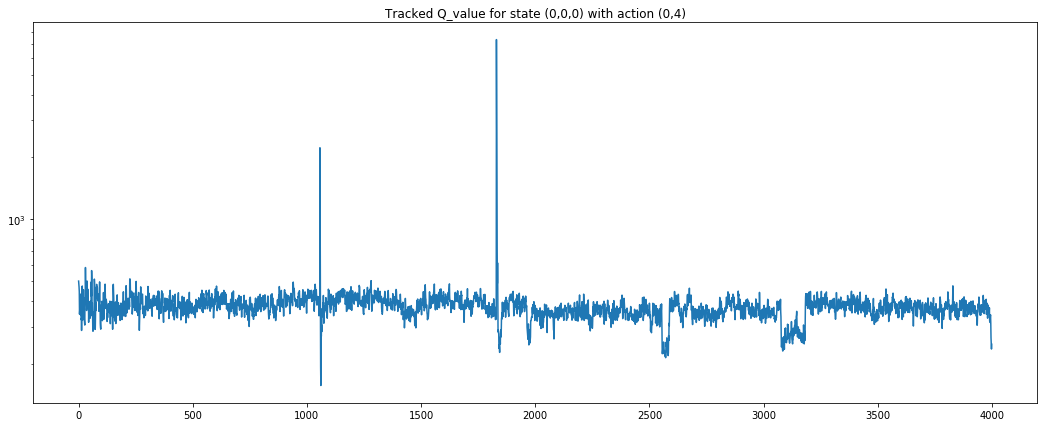

In [15]:
plt.figure(0, figsize=(18,7))
plt.title('Tracked Q_value for state (0,0,0) with action (0,4)')
x_axis = np.asarray(range(0, len(agent.states_tracked)))
plt.semilogy(x_axis,np.asarray(agent.states_tracked))
plt.show()

In [24]:
#checking Q values of (0,0,0) state action (0,4)
print('Mean Q_Value: {} and median is :{} \n'.format(np.mean(agent.states_tracked),np.median(agent.states_tracked)))
print(agent.states_tracked)


Mean Q_Value: 377.72454833984375 and median is :375.3432312011719 

[501.43567, 486.72144, 469.37552, 445.63824, 346.9328, 362.49515, 368.91068, 434.14166, 383.10733, 342.42654, 349.858, 326.36578, 330.51138, 289.4025, 334.68863, 454.6852, 474.71106, 413.5101, 324.9523, 347.7299, 382.16638, 455.28372, 379.1393, 353.05356, 350.34958, 325.7802, 315.06464, 307.35544, 417.0599, 392.90643, 583.2118, 456.98843, 397.1805, 394.48584, 397.89993, 361.3827, 380.07706, 501.6907, 433.64062, 407.56537, 458.68158, 399.40427, 371.6311, 400.3941, 317.17776, 369.9804, 397.51727, 390.74213, 381.4889, 375.00586, 359.2118, 331.97992, 401.72073, 399.9915, 340.75903, 496.35812, 423.82507, 563.6121, 518.0796, 377.25882, 392.46387, 357.7691, 300.92096, 286.8573, 326.90427, 338.56955, 354.2586, 317.11768, 302.15637, 512.6676, 483.3071, 334.9135, 292.80975, 296.3167, 339.32507, 394.79837, 361.1189, 468.5018, 417.7755, 483.59058, 443.1943, 419.64432, 467.3436, 414.2711, 402.54266, 427.89514, 407.76874, 433.4146, 

#### Inference: As we can see Q-Value of (0,0,0) state action (0,4) coverging around 375 started from near 500.

## Plotting rewards per episode

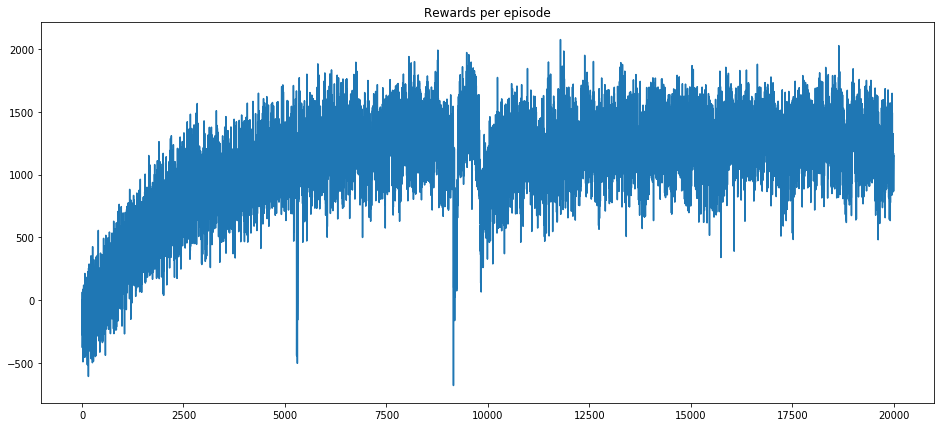

In [14]:
plt.figure(0, figsize=(16,7))
plt.title('Rewards per episode')
xaxis = np.asarray(range(0, len(rewards_per_episode)))
plt.plot(xaxis,np.asarray(rewards_per_episode))
plt.show()

#### Inference: Plotting rewards per episode, you can see that Rewards started from negative values ,after few episodes are getting approximately constant after 7500 episodes


#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [6]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

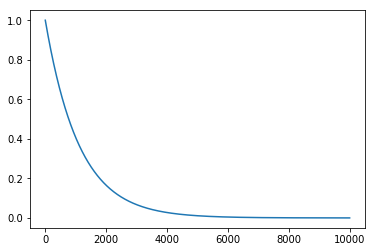

In [7]:
plt.plot(time, epsilon)
plt.show()